In [2]:
import os
import uuid
import umap
import base64
import tiktoken
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
from sklearn.mixture import GaussianMixture
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain.schema.document import Document
from typing import Dict, List, Optional, Tuple
from langchain.prompts import ChatPromptTemplate
from unstructured.partition.pdf import partition_pdf
from langchain_postgres.vectorstores import PGVector
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.messages import HumanMessage, SystemMessage

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
from unstructured.partition.pdf import partition_pdf

In [4]:
openai_api_key = os.getenv("OPENAI_API_KEY")
POSTGRES_URL_EMBEDDINDS=os.getenv("POSTGRES_URL_EMBEDDINDS")
PINECONE_API_KEY=os.getenv("PINECONE_API_KEY")

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
filename = os.path.join(root_path, "data/fy2024.pdf")
output_path = os.path.join(root_path, "data/images")

In [6]:
embd = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-4o")

NameError: name 'OpenAIEmbeddings' is not defined

In [7]:
def file_reader():
    raw_pdf_elements = partition_pdf(
        filename=filename,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=2000,
        new_after_n_chars=1500,
        extract_image_block_output_dir=output_path,
    )
    return raw_pdf_elements

In [8]:
raw_pdf_elements=file_reader()

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
raw_pdf_elements[4].to_dict()

{'type': 'Table',
 'element_id': 'bd227f10be9796d077de1a4dd421b7e6',
 'text': 'Actual Budget Adopted Projected 2021-22 2022-23 2023-24 2024-25 Personnel Costs $ 263,671,357 $ 292,444,890 $ 323,473,728 $ 336,543,344 Maintenance & Operations 313,411,029 371,734,791 405,152,078 415,447,495 Capital Outlay 12,718,236 24,750,870 22,771,021 20,580,000 Total Net Expenditures $ 589,800,622 $ 688,930,551 $ 751,341,324 $ 772,515,336',
 'metadata': {'last_modified': '2024-07-09T12:21:18',
  'text_as_html': '<table><thead><tr><th></th><th></th><th></th><th>Actual</th><th></th><th>Budget</th><th></th><th>Adopted</th><th></th><th>Projected</th></tr><tr><th></th><th></th><th></th><th>2021-22</th><th></th><th>2022-23</th><th></th><th>2023-24</th><th></th><th>2024-25</th></tr></thead><tbody><tr><td>Personnel Costs</td><td></td><td>$</td><td>263,671,357</td><td>$</td><td>292,444,890</td><td>$</td><td>323,473,728</td><td>$</td><td>336,543,344</td></tr><tr><td>Maintenance &amp; Operations</td><td></td><td>

In [ ]:
text_elements = []
text_summaries = []

table_elements = []
table_summaries = []

In [35]:
def summary_of_text_by_gpt(element_type, input):
    summary_prompt = """
    Summarize the following {element_type}:
    {element}
    """

    prompt=PromptTemplate.from_template(summary_prompt)
    llm=ChatOpenAI(model="gpt-4o", openai_api_key = openai_api_key, max_tokens=1024)
    runnable = prompt | llm

    summary = runnable.invoke({'element_type': element_type, 'element': input})
    return summary.content

In [38]:
def text_insert(raw_pdf_elements):
    i=0
    for e in raw_pdf_elements:
        if 'CompositeElement' in repr(e):
            text_elements.append(e.text)
            summary = summary_of_text_by_gpt("text",e)
            text_summaries.append(summary)

        elif 'Table' in repr(e):
            table_elements.append(e.text)
            summary = summary = summary_of_text_by_gpt("table",e)
            table_summaries.append(summary)
        print(i)
        i+=1

In [39]:
text_insert(raw_pdf_elements)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [40]:
len(text_elements)

20

In [41]:
len(table_elements)

12

In [42]:
image_elements = []
image_and_text_summaries=[]

In [43]:
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

In [44]:
def summarize_image_by_gpt(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the only text written on this image. if there is nothing written on the image then say 'No data found'"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content


In [45]:
def get_last_index_of_page():
    page_numbers=[]
    last_indices={}
    for i in range(len(raw_pdf_elements)):
        page_number=raw_pdf_elements[i].metadata.page_number
        if page_number in page_numbers:
            last_indices[page_number]=i 
        else:
            page_numbers.append(page_number)
            last_indices[page_number] = i
    return last_indices

In [46]:
last_indices=get_last_index_of_page()
last_indices

{1: 3, 2: 5, 3: 8, 4: 11, 6: 14, 7: 17, 8: 21, 9: 24, 10: 30}

In [47]:
def get_text_by_page_number(raw_pdf_elements,page_number):
    e = raw_pdf_elements[page_number]
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_of_text_by_gpt("text", e.text)
        return summary
    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_of_text_by_gpt("table", e.text)
        return summary

In [48]:
def match_text_for_no_data_found(text):
    pattern = r"no data found"
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return True
    return False


In [49]:
def image_insert_with_text(raw_pdf_elements,last_indices):
    for i in os.listdir(output_path):
        if i.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(output_path, i)
            print(i)
            img_page=i.split("-")[1]
            page_num = int(img_page)
            ind=0
            t=True
            while len(last_indices)>ind and t:
                if page_num in last_indices and page_num>=0:
                    text_page=last_indices[page_num]
                    t=False
                elif page_num>0:
                    page_num=page_num-1
                else:
                    print("not found text for ",img_page)
                    t=False
                    text_page=0
                ind+=1
            if text_page==0:
                continue
            encoded_image = encode_image(image_path)
            img_summary = summarize_image_by_gpt(encoded_image)
            print("img summary:- ",img_summary)
            if not match_text_for_no_data_found(img_summary):
                image_elements.append(encoded_image)
                text_summery=get_text_by_page_number(raw_pdf_elements,text_page)
                print("text sumary:- ",text_summery)
                image_and_text_summaries.append(img_summary+" "+ text_summery)

In [50]:
image_insert_with_text(raw_pdf_elements,last_indices)

figure-2-2.jpg
img summary:-  No data found.
figure-5-5.jpg
img summary:-  The text written on the image is:

- "Debt Service 6%"
- "Community Services 7%"
- "General Government 10%"
- "Public Safety 25%"
- "Total Budget: $751,341,324"
- "Infrastructure 52%"
text sumary:-  The text outlines budget details for the fiscal year 2023-2024, highlighting total net budget figures and allocations across different service areas. Key figures include a total net budget of $751,341,324, with significant expenditures allocated to infrastructure (52%), general government (10%), and debt service (6%). Revenue estimates are derived from prior year actuals, current year projections, trend analysis, and economic forecasts.
figure-11-13.jpg
img summary:-  The text on the image reads:

- "Total Budget: $751,341,324"
- "General Fund 44%"
- "Enterprise Funds 34%"
- "Debt Service Fund 5%"
- "Special Rev. Funds 2%"
text sumary:-  The adopted budget for the fiscal year 2023-24 totals $751,341,324, as outlined 

In [51]:
image_and_text_summaries

['The text written on the image is:\n\n- "Debt Service 6%"\n- "Community Services 7%"\n- "General Government 10%"\n- "Public Safety 25%"\n- "Total Budget: $751,341,324"\n- "Infrastructure 52%" The text outlines budget details for the fiscal year 2023-2024, highlighting total net budget figures and allocations across different service areas. Key figures include a total net budget of $751,341,324, with significant expenditures allocated to infrastructure (52%), general government (10%), and debt service (6%). Revenue estimates are derived from prior year actuals, current year projections, trend analysis, and economic forecasts.',
 'The text on the image reads:\n\n- "Total Budget: $751,341,324"\n- "General Fund 44%"\n- "Enterprise Funds 34%"\n- "Debt Service Fund 5%"\n- "Special Rev. Funds 2%" The adopted budget for the fiscal year 2023-24 totals $751,341,324, as outlined in the fund summary. This includes allocations for Internal Service Funds.',
 'Internal Service Funds\n15% The adopted

In [52]:
documents = []
retrieve_contents = []
docs_texts=[]

def get_docummets():
    for e, s in zip(text_elements, text_summaries):
        i = str(uuid.uuid4())
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'text',
                'original_content': e
            }
        )
        retrieve_contents.append((i, e))
        documents.append(doc)
        docs_texts.append(e)
    print("text_element done")

    for e, s in zip(table_elements, table_summaries):
        i = str(uuid.uuid4())
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'table',
                'original_content': e
            }
        )
        retrieve_contents.append((i, e))
        documents.append(doc)
        docs_texts.append(e)
    
    print("table_elements done")

    for e, s in zip(image_elements, image_and_text_summaries):
        i = str(uuid.uuid4())
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'image',
                'original_content': e
            }
        )
        retrieve_contents.append((i, s))
        documents.append(doc)
        docs_texts.append(s)

    print("image_elements Done")


In [53]:
get_docummets()

text_element done
table_elements done
image_elements Done


In [54]:
len(docs_texts)

34

In [55]:


RANDOM_SEED = 224 


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """
    Give a detailed summary of the provided context : {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [56]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 8 clusters--
--Generated 1 clusters--


In [57]:
results

{1: (                                                 text  \
  0   TOTAL BUDGET - EXPENDITURES\n\nThe FY 23-24 ne...   
  1   TOTAL BUDGET - EXPENDITURES\n\nThe FY 23-24 ne...   
  2   The Public Safety service area increases from ...   
  3   The Debt Service service area increases from $...   
  4   The budget includes a 4% average merit increas...   
  5   Adopted 2023-24 Budget\n\n21\n\nSERVICE AREA S...   
  6   Community Services\n\nGeneral Government Budge...   
  7   Less Transfers and Internal Charges\n\nTOTAL N...   
  8   Property Taxes The FY 23-24 recommended budget...   
  9   Sales tax revenue for FY 23-24 is projected at...   
  10  Telecommunications, video, and satellite reven...   
  11  Budgeted revenues for FY 23-24 are $276.6 mill...   
  12  The General Fund contribution to the Debt Serv...   
  13  PROPERTY TAX RATE\n\nThe property tax rate for...   
  14  Assessed Valuation\n\nFY 04-05* FY 05-06 FY 06...   
  15  TOTAL BUDGET - POSITION CHANGES\n\nThe accompa.

In [58]:

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

In [59]:
len(all_texts)

43

In [60]:
all_texts

["TOTAL BUDGET - EXPENDITURES\n\nThe FY 23-24 net budget (for all funds) of $751,341,324 is $62,410,773 million, or 9.1%, higher than the revised FY 22-23 budget.\n\nThe Infrastructure service area is the largest portion of the total budget, at $390.2 million, or 52%, of the total budget. The service area budget is $34.0 million, or 9.5%, greater than the revised current year budget. The Water Resources Fund increases from $148.6 million to $166.2 million, a difference of $17.6 million. Balancing current financing, or “pay-as-you-go” capital project financing with debt financing, Water Resources will transfer $32.7 million to various capital reserve and capital improvement funds for significant system maintenance projects.\n\nThe Field Operations Department budget includes funding necessary to meet increased costs associated with the City's solid waste collections program. Net costs for these programs increase by $2 million in FY 23-24 due to projected inflationary and tonnage increase

In [61]:
len(all_texts)

43

In [62]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

<function matplotlib.pyplot.show(close=None, block=None)>

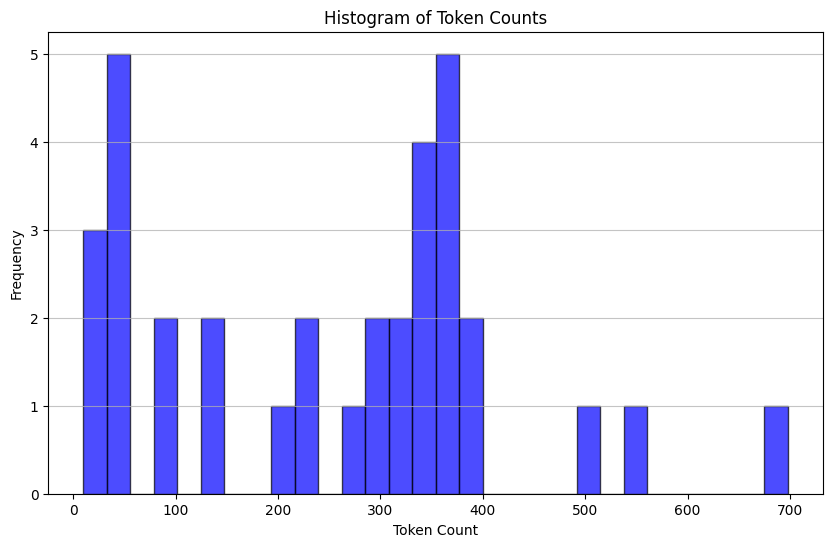

In [63]:
# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [64]:
documents=[]

In [65]:
def get_documents_with_raptor(raptor_text):
    for s in raptor_text:
        i = str(uuid.uuid4())
        doc = Document(
            page_content = s,
            metadata = {
                'id': i,
                'type': 'text',
                'original_content': s
            }
        )
        documents.append(doc)

    return documents

text_element done


In [66]:
documents

[Document(page_content="TOTAL BUDGET - EXPENDITURES\n\nThe FY 23-24 net budget (for all funds) of $751,341,324 is $62,410,773 million, or 9.1%, higher than the revised FY 22-23 budget.\n\nThe Infrastructure service area is the largest portion of the total budget, at $390.2 million, or 52%, of the total budget. The service area budget is $34.0 million, or 9.5%, greater than the revised current year budget. The Water Resources Fund increases from $148.6 million to $166.2 million, a difference of $17.6 million. Balancing current financing, or “pay-as-you-go” capital project financing with debt financing, Water Resources will transfer $32.7 million to various capital reserve and capital improvement funds for significant system maintenance projects.\n\nThe Field Operations Department budget includes funding necessary to meet increased costs associated with the City's solid waste collections program. Net costs for these programs increase by $2 million in FY 23-24 due to projected inflationar

In [67]:
def add_docs_to_postgres(collection_name):
    vectorstore = PGVector(embeddings=embd,collection_name=collection_name,connection=POSTGRES_URL_EMBEDDINDS,use_jsonb=True,)
    vectorstore.add_documents(documents)

In [68]:
collection_name="fy2024_raptor"
add_docs_to_postgres(collection_name)